# Extract Largest Eigenvalue of Symmetric Matrix with a Neural Network

In [40]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import LatinHypercube
import os

In [2]:
# Own implementations
%load_ext autoreload
%autoreload 2
from pinn2 import *

In [30]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [31]:
plt.style.use('../misc/report.mplstyle')

# Toggle to save plots as pdf
save=False
save_dir = "../../../tex/02_neural_nets_on_pdes/img/"

# Some shorthands for figure labels/legends
MSE = r"$\mathrm{MSE}_\mathcal{V}$"

In [3]:
# Double-precision by default
torch.set_default_dtype(torch.float32)

In [4]:
def power_iteration(A, N=100):
    eigenvector = np.random.rand(A.shape[0])
    for i in range(N):
        eigenvector = A @ eigenvector
        norm = np.linalg.norm(eigenvector)
        eigenvector /= norm
    return eigenvector

### Helper functions

In [5]:
def rejection_sampling(pdf, n=1000, xmin=0, xmax=.98):
    x=torch.linspace(xmin,xmax,1000)  
    y=pdf(x)  
    pmin=0.  
    pmax=y.max()  
   
    naccept=0  
   
    ran=[] # output list of random numbers  
    while naccept<n:  
        x = (xmax - xmin) * torch.rand(1) + xmin  
        y = (pmax - pmin) * torch.rand(1) + pmin   
        
        if y<pdf(x):  
            ran.append(x)  
            naccept=naccept+1  
    
    return np.asarray(ran)  

def generate_random_symmetric_matrix(dim):
    M_random = torch.rand((dim,dim)) - 0.5
    return 0.5 * (M_random.T + M_random)

def eigenvalue_of_eigenvector(x, A):
    return (x @ A @ x.T) / (x @ x.T)

def noop(y, tau):
    return torch.zeros_like(y), torch.zeros_like(y)

### ODE specification

In [14]:
random_matrix = False

if random_matrix:
    dim = 6
    A = generate_random_symmetric_matrix(dim).float()
else:
    A = torch.tensor(1/4 * np.array([[1,2,3,4,5],[2,-1,-2,-3,-4],[3,-2,1,1,1],[4,-3,1,0,0],[5,-4,1,0,0]])).float()
    dim = A.shape[-1]
    
assert np.allclose(A, A.T, rtol=1e-8, atol=1e-10)
print(f"A = {A}")

# Coordinate transformations to bring the infinite time domain t \in [0,inf) to tau \in [0,1)

def dtau_dt_inv_identity(tau):
    return torch.ones_like(tau)

def dtau_dt_inv_tan(tau):
    """
    Assuming t = tan(pi/2 * tau) this is (dtau/dt)^(-1)
    """
    return torch.pi/(2 * torch.cos(torch.pi/2 * tau)**2)

def dtau_dt_inv_arctanh(tau):
    """
    Assuming t = arctanh(tau) this is (dtau/dt)^(-1)
    """
    return 1.0/(1.0 - tau**2)

# Random intial vector as initial condition. Function attributes used to fix the random vector across calls
def ic(y, tau):
    return y - ic.y0, torch.zeros_like(y)
ic.y0 = torch.rand(dim).reshape(1,-1)
#ic.y0 = ic.y0 @ A @ A @ A @ A
ic.y0 /= torch.sqrt(ic.y0 @ ic.y0.T).item()

# We can interpret the conservation property (d/dtau (y@y.T) = 0) of the ODE as boundary condition. 
# Note that we compare against a scalar property (the norm) and not a vector. Hence the difference in 
# the second return argument compared to ic() or eigenvector_ode()
def norm_conservation(y, tau):
    return torch.sqrt((y[:,None,:] @ y[:,:,None]).squeeze(-1)) - 1, torch.zeros_like(tau)

def eigenvector_ode(y, tau):    
    # Left hand side (LHS) of ODE
    y_tau = derivative(y, tau)
    # Right hand side (RHS) of ODE
    first_term = (y[:,None,:] @ (y[:,None,:] @ y[:,:,None] * A)).squeeze()
    second_term = (y[:,None,:] @ A @ y[:,:,None] @ y[:,None,:]).squeeze()
    #Prefactor of LHS due to coordinate transformation
    dtau_dt_inv = dtau_dt_inv_identity(tau)
    return y_tau - dtau_dt_inv * (first_term - second_term), torch.zeros_like(y)
eigenvector_ode.domain_dim=1
eigenvector_ode.target_dim=dim

# A solution form that adheres to the initial conditions explicitly
def trial_function(net_output, tau):
    return ic.y0 + tau * net_output
    
def temporal_sample(T, N_t, N_ic, N_bc, kind="lhs", function=dtau_dt_inv_identity):
    if kind == "lhs":
        sampler = lambda N: torch.from_numpy(T * LatinHypercube(1).random(n = N)).float()
    elif kind == "uniform":
        sampler = lambda N: torch.from_numpy(np.linspace(0.01, .99*T, N).reshape(-1,1)).float()
    elif kind == "rejection":
        sampler = lambda N: torch.from_numpy(rejection_sampling(function, n=N, xmin=0.01, xmax=.99*T)).reshape(-1,1).float()
    
    #Interior points
    samples_t = sampler(N_t)
    
    # Initial condition
    samples_t_ic = torch.zeros((N_ic, 1))
    
    #Boundary conditions
    samples_t_bc = sampler(N_bc)
    
    return samples_t, \
           samples_t_ic, \
           samples_t_bc

A = tensor([[ 0.2500,  0.5000,  0.7500,  1.0000,  1.2500],
        [ 0.5000, -0.2500, -0.5000, -0.7500, -1.0000],
        [ 0.7500, -0.5000,  0.2500,  0.2500,  0.2500],
        [ 1.0000, -0.7500,  0.2500,  0.0000,  0.0000],
        [ 1.2500, -1.0000,  0.2500,  0.0000,  0.0000]])


### Function Hooks used for training monitoring

In [7]:
def monitor_eigenvector_evolution(net):
    x = torch.tensor([1.]).reshape(1,1)
    coordinates = [
                    c.reshape(-1, 1) for c in torch.unbind(x, dim=-1)
    ]
    return trial_function(net(x), *coordinates).numpy()

def monitor_eigenvalue_evolution(net):
    return eigenvalue_of_eigenvector(monitor_eigenvector_evolution(net), A.numpy())

### Generate Dataset

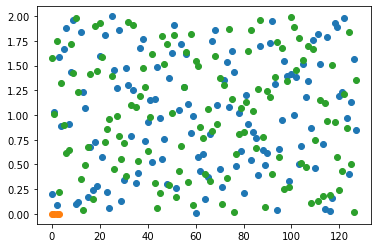

In [24]:
#IBVP parameters
N_interior =  2**7
N_bc = 2**7
N_ic = 4
T = 2

# Generate training set
X_train = temporal_sample(T, N_interior, N_ic, N_bc, kind="lhs")
t_int, t_ic, t_bc = X_train

# Generate test data
X_test = temporal_sample(T, N_interior, N_ic, N_bc, kind="lhs")
t_int, t_ic, t_bc = X_test

plt.scatter(np.arange(len(t_int)), t_int)
plt.scatter(np.arange(len(t_ic)), t_ic)
plt.scatter(np.arange(len(t_bc)), t_bc)

plt.show()

### Train the Network

In [18]:
def early_convergence(loss):
    if np.abs(1.0 - loss / early_convergence.last_loss) < 1e-10:
        return True
    else:
        early_convergence.last_loss = loss
        return False
early_convergence.last_loss = np.inf
early_convergence.terminate = True

hp = {"optimizer":"adam", 
      "optimizer_params":{"lr":1e-3}, 
      "hidden_layers":[30,30,30], 
      "number_of_minibatches":1,
      "epochs":10000}

eigen_nn = PiNN(eigenvector_ode, noop, noop, trial_function, 
                hooks=[monitor_eigenvalue_evolution, monitor_eigenvector_evolution],
                events_for_loss=[early_convergence],
                verbose=True, hyperparameters=hp)
print(eigen_nn)
eigen_nn.fit(X_train)

NN(
  (ff_graph): Sequential(
    (0): Linear(in_features=1, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
  )
  (output): Linear(in_features=30, out_features=5, bias=True)
)
model parameters:                                                 2075
---------------------------Hyperparameters----------------------------
hidden_layers                                             [30, 30, 30]
epochs                                                           10000
number_of_minibatches                                                1
optimizer_name                                                   lbfgs
optimizer_params                                         {'lr': 0.001}

-----------------------------Training Log-----------------------------
# of collocation points:                                           128
# of boundary points:              

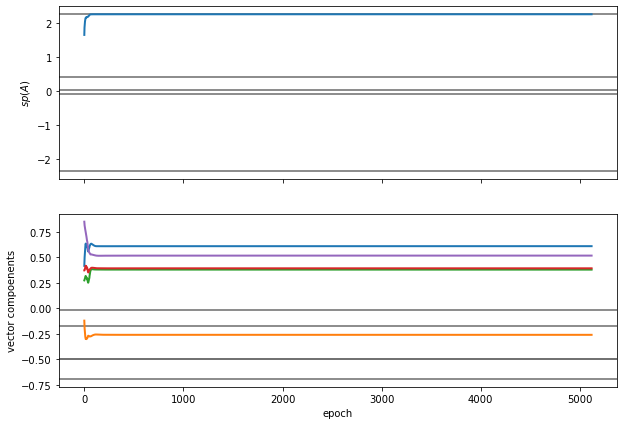

In [23]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,7))
for ev in eigenvalues:
    ax[0].axhline(y=ev, color="dimgray")
for component in eigenvectors[closest_ev_idx]:
    ax[1].axhline(y=component, color="dimgray")

ev_evolution = np.array(eigen_nn.hooks_returns["monitor_eigenvalue_evolution"]).squeeze()
vector_evolution = np.array(eigen_nn.hooks_returns["monitor_eigenvector_evolution"]).squeeze().T
ax[0].plot(ev_evolution, lw=2)
for element_evolution in vector_evolution:
    ax[1].plot(element_evolution, lw=2)
ax[1].set_xlabel(r"epoch")
ax[0].set_ylabel(r"$sp(A)$")
ax[1].set_ylabel(r"vector compoenents")
plt.show()

## Hyperparameter Tuning

In [44]:
from ray.tune.schedulers import ASHAScheduler

def no_increasing_loss(trial_id, result):
    if result["training_iteration"] == 1:
        no_increasing_loss.max_loss = result["validation_loss"]
        return False
    return result["validation_loss"] > no_increasing_loss.max_loss

parameter_space = {
    "layers": tune.randint(1, 4),
    "nodes": tune.randint(5,40),
    "activation_function": tune.choice([nn.Tanh(),nn.ReLU()]),
    "optimizer_name": tune.choice(["lbfgs","adam"]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "number_of_minibatches": 1
}
reasonable_start = [
    {
        "layers": 3,
        "nodes": 20,
        "activation_function": nn.Tanh(),
        "optimizer_name": "lbfgs",
        "lr": 1e-3,
    }
]

fixed_parameters = {
    "epochs": 1000
}


eigen_nn = PiNN(eigenvector_ode, noop, noop, trial_function, 
                hyperparameters=fixed_parameters, verbose=False)
scheduler=ASHAScheduler(max_t=fixed_parameters["epochs"], grace_period=5, brackets=3)

analysis = tune.run(tune.with_parameters(eigen_nn.train, X_train=X_train, X_test=X_test),
                    config=parameter_space,
                    num_samples=200,
                    max_failures=2,
                    metric="validation_loss",
                    mode="min",
                    scheduler=scheduler,
                    stop=no_increasing_loss,
                    local_dir="../data/ray",
                    name="eigen_pinn",
                    resume="AUTO",
                    verbose=1)

2022-04-24 20:36:40,032	INFO tune.py:701 -- Total run time: 0.60 seconds (0.00 seconds for the tuning loop).


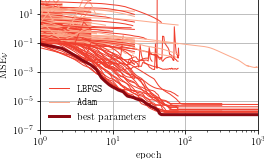

In [45]:
save=True
size = (3.9, 0.618 * 3.9) if save else (10,6)

fig, ax = plt.subplots(figsize=size)
ax.set_xscale("log")
ax.set_yscale("log")

dfs = analysis.trial_dataframes
best_df = analysis.best_dataframe
best_cfg = analysis.best_config

blues = sns.color_palette("Reds",12)

for k,d in dfs.items():
    if "adam" in k:
        line_adam, = ax.plot(d.training_iteration, d.validation_loss, color=blues[3], lw=1)
    else:
        line_lbfgs, = ax.plot(d.training_iteration, d.validation_loss, color=blues[7], lw=1)
        
ax.plot(best_df.training_iteration, best_df.validation_loss, color=blues[11], lw=3, label=r"best parameters")
line_adam.set_label(rf"\texttt{{Adam}}")
line_lbfgs.set_label(rf"\texttt{{LBFGS}}")
ax.set_ylim([1e-7,1e2])
ax.set_xlabel(r"epoch")
ax.set_ylabel(MSE)
handles, labels = ax.get_legend_handles_labels()
#handles[0], handles[1] = handles[1], handles[0]
#labels[0], labels[1] = labels[1], labels[0]
ax.legend(handles, labels)

if save:
    fig.savefig(save_dir + "hyperopt_eigenvector.pdf",bbox_inches="tight",pad_inches = 0.02)
else:
    plt.show()

In [41]:
logdir = analysis.best_logdir
best_cfg["hidden_layers"] = best_cfg["layers"] * [best_cfg["nodes"]]
best_cfg["optimizer_params"] = {"lr":best_cfg["lr"]}
best_cfg = best_cfg | fixed_parameters
state_dict = torch.load(os.path.join(logdir, "model.pth"))
print(best_cfg)

{'layers': 3, 'nodes': 25, 'activation_function': Tanh(), 'optimizer_name': 'lbfgs', 'lr': 0.05692258479064706, 'number_of_minibatches': 1, 'hidden_layers': [25, 25, 25], 'optimizer_params': {'lr': 0.05692258479064706}, 'epochs': 1000}


### Comparison between PiNN and Numpy

In [36]:
#Ground Truth
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Sort in descending order
permutation = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[permutation]
eigenvectors = eigenvectors[permutation]
print(f"Sp(A) = {eigenvalues}")
print(f"max{{ Sp(A) }} = {np.max(eigenvalues)}")
print(f"eigenvector = {eigenvectors[0]}")

Sp(A) = [ 2.2536652   0.41407576  0.01711813 -0.07780847 -2.3570507 ]
max{ Sp(A) } = 2.2536652088165283
eigenvector = [-0.49519905 -0.02144955 -0.69146746 -0.16907792 -0.49759743]


In [43]:
best_eigen_nn = PiNN(eigenvector_ode, noop, noop, trial_function, 
                hyperparameters=best_cfg, verbose=False)
best_eigen_nn.net.load_state_dict(state_dict)

x = best_eigen_nn.predict(torch.tensor([1.]).reshape(1,1))
ev_from_network = eigenvalue_of_eigenvector(x, A.numpy()).item()   
closest_ev_idx = np.argmin(np.abs(eigenvalues - ev_from_network))

print(f"eigenvalue (network) = {ev_from_network}")
print(f"eigenvector (network) = {x}")
print(f"closest eigenvalue = {eigenvalues[closest_ev_idx]}")
print("Overlaps of IC")
for eigenvector, eigenvalue in zip(eigenvectors, eigenvalues):
    print(np.abs(ic.y0 @ eigenvector), eigenvalue)

eigenvalue (network) = 2.249629259109497
eigenvector (network) = tensor([[ 0.6092, -0.2589,  0.3780,  0.3911,  0.5160]])
closest eigenvalue = 2.2536652088165283
Overlaps of IC
tensor([0.8171]) 2.2536652
tensor([0.4074]) 0.41407576
tensor([0.3104]) 0.017118132
tensor([0.2629]) -0.07780847
tensor([0.0286]) -2.3570507
